In [1]:
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle
from mytools import Video, get_cuts

from tqdm.notebook import tqdm

2023-12-03 02:22:27.022601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from icecream import ic
ic.disable()

# Define Spliter and Generator

## Used functions

In [3]:
def get_cuts_df(video, cuts, frames_before=2, frames_after=2):
    """
    Returns table of frames indices arround cuts.
    
    Parameters:
    video : mytools.Video
    
    cuts : int-array
    
    frames_before : int
    
    frames_after : int
    """
    df = np.arange(-frames_before, frames_after).reshape([1, frames_before + frames_after]) + cuts.reshape([len(cuts), 1])
    df = pd.DataFrame(df).astype(int)
    return df

In [4]:
def get_noncuts_df(video, cuts, frames_before=2, frames_after=2):
    """
    Returns table of frames indices arround noncuts.
    
    Parameters:
    video : mytools.Video
    
    cuts : int-array
    
    frames_before : int
    
    frames_after : int
    """
    noncuts = np.arange(len(video))
    noncuts = noncuts[np.logical_not(np.isin(noncuts, cuts))]
    noncuts = noncuts[noncuts >= frames_before]
    noncuts = noncuts[noncuts < len(video) - frames_after]
    df = np.arange(-frames_before, frames_after).reshape([1, frames_before + frames_after]) + noncuts.reshape([len(noncuts), 1])
    df = pd.DataFrame(df).astype(int)
    return df

In [5]:
def get_frames_from_row(row, videos, frames_before=2, frames_after=2, video_size=None, rescale=None):
    """
    """
    res = []
    for i in range(frames_before):
        res.append(videos[row['before']].get_frame(row[i], new_size=video_size))
    for i in range(frames_before, frames_before + frames_after):
        res.append(videos[row['after']].get_frame(row[i], new_size=video_size))
    res = np.array(res)
    if rescale is not None:
        res = res*rescale
    return res

## Iterator and Generator classes

In [6]:
class TableVideoIterator:
    def __init__(self, videos, df: pd.DataFrame, frames_before=2, frames_after=2, 
                 batch_size=64, video_size=None, rescale=None, shuffle=True):
        """
        Yields batches (X, y)
        
        Parameters:
        -----------
        videos : dict, with mytools.Video values
        
        df : pd.DataFrame, columns: 'before' - str, videos keys
                                    'after' - str, videos keys
                                    'cut' - bool, 
                                    0, 1, ..., (frames_before + frames_after - 1) - int
        
        frames_before : int
        
        frames_after : int
        
        batch_size : int
        
        video_size : None or tuple with 2 integers
            Change video size if not None
        
        """
        ic()
        self.videos = videos
        self.df = df.reset_index(drop=False)
        self.frames_before = frames_before
        self.frames_after = frames_after
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.rescale = rescale
        self.video_size = video_size
        self.indexes = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indexes)
        self.batch_index = 0
        
    def reshuffle(self):
        self.indexes = np.arange(len(self.df))
        if shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return (len(self.df) - 1)//self.batch_size + 1
    
    def on_epoch_end(self):
        ic()
        self.batch_index = 0
        self.reshuffle()
        ic()
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError(
                "Asked to retrieve element {idx}, "
                "but the Sequence "
                "has length {length}".format(idx=idx, length=len(self))
            )
        if idx == len(self) - 1:
            indexes_i = self.indexes[idx*self.batch_size:]
        else:
            indexes_i = self.indexes[idx*self.batch_size:(idx + 1)*self.batch_size]
        X = []
        for i in indexes_i:
            X.append(get_frames_from_row(self.df.loc[i], self.videos, 
                                         frames_before=self.frames_before, 
                                         frames_after=self.frames_after, 
                                         video_size=self.video_size, 
                                         rescale=self.rescale))
        X = np.array(X)
        y = self.df.loc[indexes_i, 'cut'].values.astype(int)
        ic(X.shape, y.shape)
        return X, y
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.batch_index += 1
        if self.batch_index > len(self):
            ic()
            self.on_epoch_end()
            raise StopIteration
        return self[self.batch_index - 1]

In [7]:
class TableVideoGenerator:
    def __init__(self, videos, df: pd.DataFrame, frames_before=2, frames_after=2, 
                 batch_size=64, video_size=None, rescale=None):
        """
        """
        self.videos = videos
        self.df = df.copy()
        self.batch_size = batch_size
        self.rescale = rescale
        self.video_size = video_size
        self.frames_before = frames_before
        self.frames_after = frames_after
        
    def __len__(self):
        return (len(self.df) - 1)//self.batch_size + 1
    
    def flow(self, infinite=True):
        while True:
            ic()
            for X, y in TableVideoIterator(videos=self.videos, df=self.df, 
                                           frames_before=self.frames_before, frames_after=self.frames_after, 
                                           batch_size=self.batch_size, 
                                           video_size=self.video_size, rescale=self.rescale, shuffle=True):
                yield X, y
            ic()
            if not infinite:
                break

## Spliter class

In [8]:
class Spliter:
    def __init__(self, video_paths, cuts_paths, frames_before=2, frames_after=2):
        """
        """
        if len(video_paths) != len(cuts_paths):
            raise ValueError("video_paths and cuts_paths have different lengths.")
        self.frames_before = frames_before
        self.frames_after = frames_after
        self.filenames = np.array(video_paths)
        self.videos = {}
        self.cuts = {}
        for i in range(len(video_paths)):
            self.videos.update({video_paths[i] : Video(video_paths[i])})
            ic(cuts_paths[i][video_paths[i].find('.'):] )
            if cuts_paths[i][cuts_paths[i].find('.'):] == '.kdenlive':
                self.cuts.update({video_paths[i] : get_cuts(cuts_paths[i])})
            elif cuts_paths[i][cuts_paths[i].find('.'):] == '.npy':
                self.cuts.update({video_paths[i] : np.load(cuts_paths[i]).astype(int)})
            else:
                raise ValueError("Wrong file format")
        ic(self.videos.keys(), self.cuts.keys())
        self.df = pd.DataFrame(columns=['before', 'after', 'cut'])
        self.df = self.df.astype({'before' : str, 'after' : str, 'cut' : bool})
    
    def define_cuts(self):
        """
        """
        for filename in self.filenames:
            dfi = get_cuts_df(self.videos[filename], self.cuts[filename], 
                              frames_before=self.frames_before, frames_after=self.frames_after)
            dfi['cut'] = True
            dfi['before'] = filename
            dfi['after'] = filename
            self.df = pd.concat([self.df, dfi], ignore_index=True)
        for i in range(self.frames_before + self.frames_after):
            self.df = self.df.astype({i: int})
            
    def define_noncuts(self):
        """
        """
        for filename in self.filenames:
            dfi = get_noncuts_df(self.videos[filename], self.cuts[filename], 
                                 frames_before=self.frames_before, frames_after=self.frames_after)
            dfi['cut'] = False
            dfi['before'] = filename
            dfi['after'] = filename
            self.df = pd.concat([self.df, dfi], ignore_index=True)
        for i in range(self.frames_before + self.frames_after):
            self.df = self.df.astype({i: int})
            
    def define(self, portion=1):
        """
        """
        self.define_cuts()
        self.define_noncuts()
        self.df = self.df.drop_duplicates()
        if portion < 1:
            n = len(self.df)
            idx = np.arange(n)
            idx = np.sort(np.random.choice(idx, int(portion*n)))
            self.df = self.df.loc[idx].reset_index(drop=True)
        
    def reduce_noncuts(self, p=1):
        # save p part of noncuts in self.df (reducing 1-p part)
        df_cuts = self.df[self.df['cut'] == True]
        df_noncuts = self.df[self.df['cut'] == False]
        df_noncuts = shuffle(df_noncuts, n_samples=int(p*len(df_noncuts)))
        self.df = pd.concat([df_cuts, df_noncuts]).reset_index(drop=True)
        ic(self.df.head(), self.df.shape)
        
    def split(self, validation_portion=0.2):
        """
        """
        n = int(len(self.df)*validation_portion)
        idx = self.df.index.values
        np.random.shuffle(idx)
        self.df_validation = pd.DataFrame(self.df.values[idx[:n]], columns=self.df.columns)
        self.df_training = pd.DataFrame(self.df.values[idx[n:]], columns=self.df.columns)
    
    def reduce_splited(self, p_validation=1, p_training=1):
        # Resuce self.df_validation and self.df_training
        self.df_validation = shuffle(self.df_validation, n_samples=int(p_validation*len(self.df_validation))).reset_index(drop=True)
        self.df_training = shuffle(self.df_training, n_samples=int(p_training*len(self.df_training))).reset_index(drop=True)
        
    
    
    def len_training_cuts(self):
        # return number of cut-rows in training table
        return len(self.df_training[self.df_training['cut'] == True])
    
    def len_training_noncuts(self):
        # return number of noncut-rows in training table
        return len(self.df_training[self.df_training['cut'] == False])
    
    def len_validation_cuts(self):
        # return number of cut-rows in validation table
        return len(self.df_validation[self.df_validation['cut'] == True])
    
    def len_validation_noncuts(self):
        # return number of noncut-rows in validation table
        return len(self.df_validation[self.df_validation['cut'] == False])
    
    def augment_cuts(self, n=0, near_val=2):
        """
        Add augmentated cuts to training table.
        
        Parameters:
        -----------
        n : int
            Number of augmneting and adding cut-rows.
        
        near_val : int
            If cut is got from one video and the neighbou frames are in destace less n in original: remove that cut-rows.
        """
        df_noncut = self.df_training[self.df_training['cut'] == False].reset_index(drop=True)
        begins = np.random.randint(len(df_noncut), size=[n, 2])
        df_before = df_noncut.loc[begins[:, 0], np.append('before', np.arange(self.frames_before, dtype=object))].reset_index(drop=True)
        df_after = df_noncut.loc[begins[:, 1], np.append('after', np.arange(self.frames_before, self.frames_before + self.frames_after, dtype=object))].reset_index(drop=True)
        df_augcut = pd.concat([df_before,df_after], axis=1)
        df_augcut['cut'] = True
        df_augcut = df_augcut[np.concatenate([['before', 'after', 'cut'], np.arange(self.frames_before + self.frames_after, dtype=object)])]
        df_augcut = df_augcut.astype({'cut' : bool})
        near = (abs(df_augcut[self.frames_before] - df_augcut[self.frames_before - 1]) < near_val) & (df_augcut['before'] == df_augcut['after'])
        if len(df_augcut[near]) != 0:
            msg = f'\nGot {len(df_augcut[near])} extremly near cut rows:\n' 
            msg += str(df_augcut[near])
            df_augcut = df_augcut[np.logical_not(near)]
            msg += '\nSo removed them.'
            warnings.warn(msg)
            
        
        self.df_training = self.df_training.astype({'cut' : bool})
        self.df_training = pd.concat([self.df_training, df_augcut]).reset_index(drop=True)
        self.df_training = shuffle(self.df_training)
    
    def get_validation_generator(self, batch_size=16, video_size=(160, 90), rescale=1/255):
        """
        """
        return TableVideoGenerator(videos=self.videos, df=self.df_validation, 
                                   frames_before=self.frames_before, frames_after=self.frames_after, 
                                   batch_size=batch_size, video_size=video_size, rescale=rescale)
    
    def get_training_generator(self, batch_size=64, video_size=(160, 90), rescale=1/255):
        """
        """
        return TableVideoGenerator(videos=self.videos, df=self.df_training, 
                                   frames_before=self.frames_before, frames_after=self.frames_after, 
                                   batch_size=batch_size, video_size=video_size, rescale=rescale)

# Aigment and Split Data

In [9]:
learning_indexes = [0, 1, 4, 5]
spliter = Spliter(['videos/{0}.mp4'.format(i) for i in learning_indexes], 
                  ['cuts/{0}.npy'.format(i) for i in learning_indexes], 
                  frames_before=2, frames_after=2)

In [10]:
spliter.define(portion=1)
spliter.reduce_noncuts(0.8)
spliter.split(0.12)

print('Validation set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_validation), 
                                                                       spliter.len_validation_cuts(), 
                                                                       spliter.len_validation_noncuts()))
print('Training set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_training), 
                                                                       spliter.len_training_cuts(), 
                                                                       spliter.len_training_noncuts()))

Validation set length is 2115: 109 cuts vs 2006 noncuts
Training set length is 15513: 578 cuts vs 14935 noncuts


In [11]:
spliter.augment_cuts(n=2*spliter.len_training_noncuts()//3 - spliter.len_training_cuts())

print('Training set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_training), 
                                                                       spliter.len_training_cuts(), 
                                                                       spliter.len_training_noncuts()))

Training set length is 24891: 9956 cuts vs 14935 noncuts


In [12]:
spliter.reduce_splited(1.0, 1.0)

print('Validation set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_validation), 
                                                                       spliter.len_validation_cuts(), 
                                                                       spliter.len_validation_noncuts()))
print('Training set length is {0}: {1} cuts vs {2} noncuts'.format(len(spliter.df_training), 
                                                                       spliter.len_training_cuts(), 
                                                                       spliter.len_training_noncuts()))

Validation set length is 2115: 109 cuts vs 2006 noncuts
Training set length is 24891: 9956 cuts vs 14935 noncuts


In [13]:
gen_validation = spliter.get_validation_generator(batch_size=16, video_size=(90, 160), rescale=1/255)
gen_training = spliter.get_training_generator(batch_size=128, video_size=(90, 160), rescale=1/255)


In [14]:
pbar = tqdm(total=len(gen_validation))

X_validation = []
y_validation = []

for X, y in gen_validation.flow(infinite=False):
    X_validation.append(X)
    y_validation.append(y)
    pbar.update()
pbar.close()

X_validation = np.concatenate(X_validation)
y_validation = np.concatenate(y_validation)
print(f'X_validation.shape = {X_validation.shape}\ny_validation.shape = {y_validation.shape}\n')

  0%|          | 0/133 [00:00<?, ?it/s]

X_validation.shape = (2115, 4, 160, 90, 3)
y_validation.shape = (2115,)



# Build a Model

In the architecture for fragments length 4 there are 2 convolutional layers: 
1. The layer with `kernel_size=2` should check, what the moves are in the first and the last pairs, and what's there difference in the moment of potential cut.
2. The second layer should calculate the conclusion from the first layer.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(48, 2, activation='relu', input_shape=(4, 160, 90, 3)), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    tf.keras.layers.Conv3D(64, 3, activation='relu'), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(128, activation='relu'), 
    #tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

Build a new architecture to analyze fragments length 6

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 159, 89, 48)    1200      
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 79, 44, 48)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 77, 42, 64)     83008     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 38, 21, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 51072)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [28]:
history = model.fit(gen_training.flow(),
                    steps_per_epoch=len(gen_training), 
                    epochs=4,
                    verbose=1,
                    validation_data=(X_validation, y_validation))

Epoch 1/4
195/195 [==============================] - 2607s 13s/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0456 - val_accuracy: 0.9882
Epoch 2/4
195/195 [==============================] - 2605s 13s/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0100 - val_accuracy: 0.9976
Epoch 3/4
195/195 [==============================] - 2611s 13s/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.0178 - val_accuracy: 0.9962
Epoch 4/4
195/195 [==============================] - 2608s 13s/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0105 - val_accuracy: 0.9967


In [29]:
val_loss, val_acc = model.evaluate(gen_validation.flow(), steps=len(gen_validation))
print(f'Validation loss: {val_loss}\nValidation Accuracy: {val_acc}')

133/133 [==============================] - 136s 1s/step - loss: 0.0105 - accuracy: 0.9967
Validation loss: 0.010495724156498909
Validation Accuracy: 0.9966903328895569


In [30]:
assert len(history.history['val_loss']) == len(history.epoch)

# Saving results

In [31]:
import os
import pickle
from datetime import datetime

In [32]:
now = datetime.now()
now = str(now)[:16]

print(f'Current date and timie is {now}')
now = now.replace(' ', '-').replace(':', '-')

Current date and timie is 2023-12-03 17:34


In [33]:
path_model = 'models'
path_history = 'histories'
if not os.path.isdir(path_model):
    os.mkdir(path_model)
if not os.path.isdir(path_history):
    os.mkdir(path_history)

In [34]:
path_model = os.path.join(path_model, f'{now}.h5')
path_history = os.path.join(path_history, f'{now}.pkl')

In [35]:
with open(path_history, 'wb') as file:
    pickle.dump(history, file)

In [36]:
model.save(path_model)

/home/fedora/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Learning History

In [37]:
import matplotlib.pyplot as plt

/tmp/ipykernel_4132/630523423.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


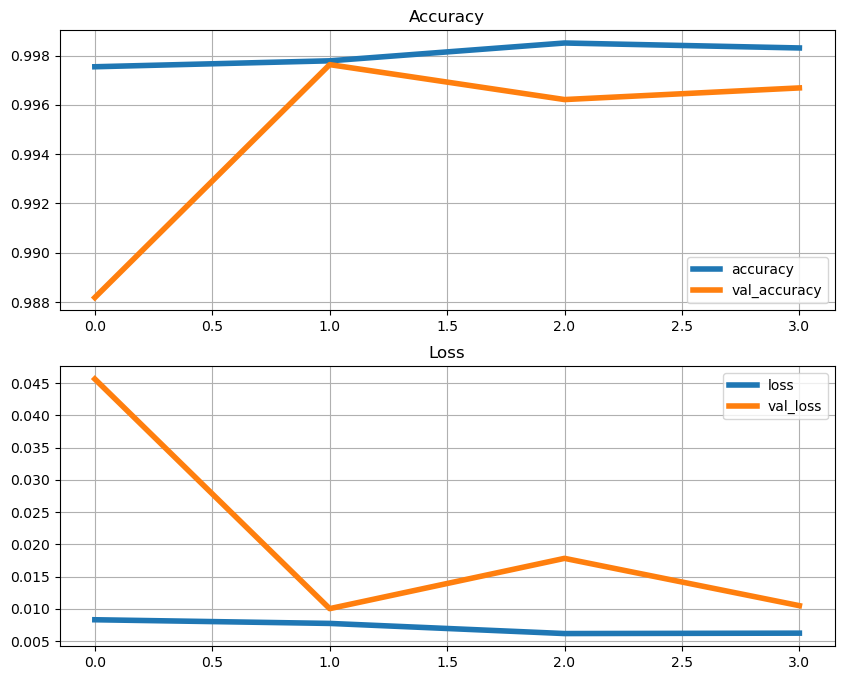

In [38]:
fig, axs = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(8)

axs[0].set_title('Accuracy')
axs[0].plot(history.epoch, history.history['accuracy'], linewidth=4, label='accuracy')
try:
    axs[0].plot(history.epoch, history.history['val_accuracy'], linewidth=4, label='val_accuracy')
except KeyError:
    axs[0].plot(history.epoch, np.ones(len(history.epoch))*val_acc, linewidth=4, linestyle='-.', label='result val_accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Loss')
axs[1].plot(history.epoch, history.history['loss'], linewidth=4, label='loss')
try:
    axs[1].plot(history.epoch, history.history['val_loss'], linewidth=4, label='val_loss')
except KeyError:
    axs[1].plot(history.epoch, np.ones(len(history.epoch))*val_loss, linewidth=4, linestyle='-.', label='result val_loss')
axs[1].legend()
axs[1].grid(True)

fig.show()